In [5]:
import pandas as pd
import numpy as np

# Cargar los archivos CSV desde la carpeta 'data'
df_train = pd.read_csv('data/train.csv')
df_features = pd.read_csv('data/features.csv')
df_stores = pd.read_csv('data/stores.csv')

In [6]:
# Inspeccionar la estructura de los datos para ver tipos y nulos
print("--- df_train Info ---")
df_train.info() 

print("\n--- df_features Info ---")
df_features.info()

print("\n--- df_stores Info ---")
df_stores.info()

--- df_train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB

--- df_features Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDo

In [7]:
# 1. Conversión de la columna 'Date' a formato datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_features['Date'] = pd.to_datetime(df_features['Date'])

print("Fechas convertidas a formato datetime.")

# 2. Unificación de los DataFrames
# 2a. Unir ventas (df_train) con características semanales (df_features)
# Usamos 'Store' y 'Date' como claves. El 'IsHoliday' se incluye como verificación, aunque no es estrictamente necesario.
df_combined = df_train.merge(df_features, on=['Store', 'Date', 'IsHoliday'], how='left')

# 2b. Unir el resultado con las características estáticas de la tienda (df_stores)
df_final = df_combined.merge(df_stores, on='Store', how='left')

# 3. Inspeccionar el DataFrame unificado
print("\n--- df_final Info después de la unión ---")
df_final.info(verbose=False)
print("\n--- df_final Head para ver la estructura ---")
print(df_final.head())

Fechas convertidas a formato datetime.

--- df_final Info después de la unión ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Columns: 16 entries, Store to Size
dtypes: bool(1), datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 48.6+ MB

--- df_final Head para ver la estructura ---
   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN   

In [8]:
# 1. Crear una Serie con la cuenta de NaNs por columna
nan_counts = df_final.isnull().sum()

# 2. Filtrar y mostrar solo las columnas que tienen NaNs (valores > 0)
nan_cols = nan_counts[nan_counts > 0]

print("--- Conteo de Valores Nulos (NaNs) en df_final ---")
print(nan_cols)

--- Conteo de Valores Nulos (NaNs) en df_final ---
MarkDown1    270889
MarkDown2    310322
MarkDown3    284479
MarkDown4    286603
MarkDown5    270138
dtype: int64


In [9]:
# Definir las columnas de MarkDown
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Imputación: Reemplazar NaN con 0.0 en esas columnas
df_final[markdown_cols] = df_final[markdown_cols].fillna(0.0)

print("Imputación a 0.0 realizada con éxito.")

# Verificación: Contar NaNs en las columnas MarkDown
nan_check = df_final[markdown_cols].isnull().sum()

print("\n--- Conteo de Valores Nulos (NaNs) después de la imputación ---")
print(nan_check)

Imputación a 0.0 realizada con éxito.

--- Conteo de Valores Nulos (NaNs) después de la imputación ---
MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64


In [10]:
# 1. Extraer Año, Mes y Semana del Año
df_final['Year'] = df_final['Date'].dt.year
df_final['Month'] = df_final['Date'].dt.month
df_final['Week'] = df_final['Date'].dt.isocalendar().week.astype(int)

# 2. Extraer Día de la Semana (0=Lunes, 6=Domingo)
df_final['DayOfWeek'] = df_final['Date'].dt.dayofweek

print("Características de tiempo creadas con éxito.")
print("\nVerificando las nuevas columnas:")
print(df_final[['Date', 'Year', 'Month', 'Week', 'DayOfWeek']].head())

Características de tiempo creadas con éxito.

Verificando las nuevas columnas:
        Date  Year  Month  Week  DayOfWeek
0 2010-02-05  2010      2     5          4
1 2010-02-12  2010      2     6          4
2 2010-02-19  2010      2     7          4
3 2010-02-26  2010      2     8          4
4 2010-03-05  2010      3     9          4


In [11]:
# Crear la característica de MarkDown total
df_final['Total_MarkDown'] = (df_final['MarkDown1'] + df_final['MarkDown2'] + 
                             df_final['MarkDown3'] + df_final['MarkDown4'] + 
                             df_final['MarkDown5'])

print("\nCaracterística 'Total_MarkDown' creada.")


Característica 'Total_MarkDown' creada.


In [12]:
# Agrupar las ventas semanales de todo Walmart por la columna 'Date'
df_ventas_semanales = df_final.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Renombrar la columna agregada para claridad
df_ventas_semanales.rename(columns={'Weekly_Sales': 'Total_Weekly_Sales'}, inplace=True)

print("\nDataFrame de Ventas Semanales Agregadas listo:")
print(df_ventas_semanales.head())
print(f"Número total de semanas para el análisis: {len(df_ventas_semanales)}")


DataFrame de Ventas Semanales Agregadas listo:
        Date  Total_Weekly_Sales
0 2010-02-05         49750740.50
1 2010-02-12         48336677.63
2 2010-02-19         48276993.78
3 2010-02-26         43968571.13
4 2010-03-05         46871470.30
Número total de semanas para el análisis: 143


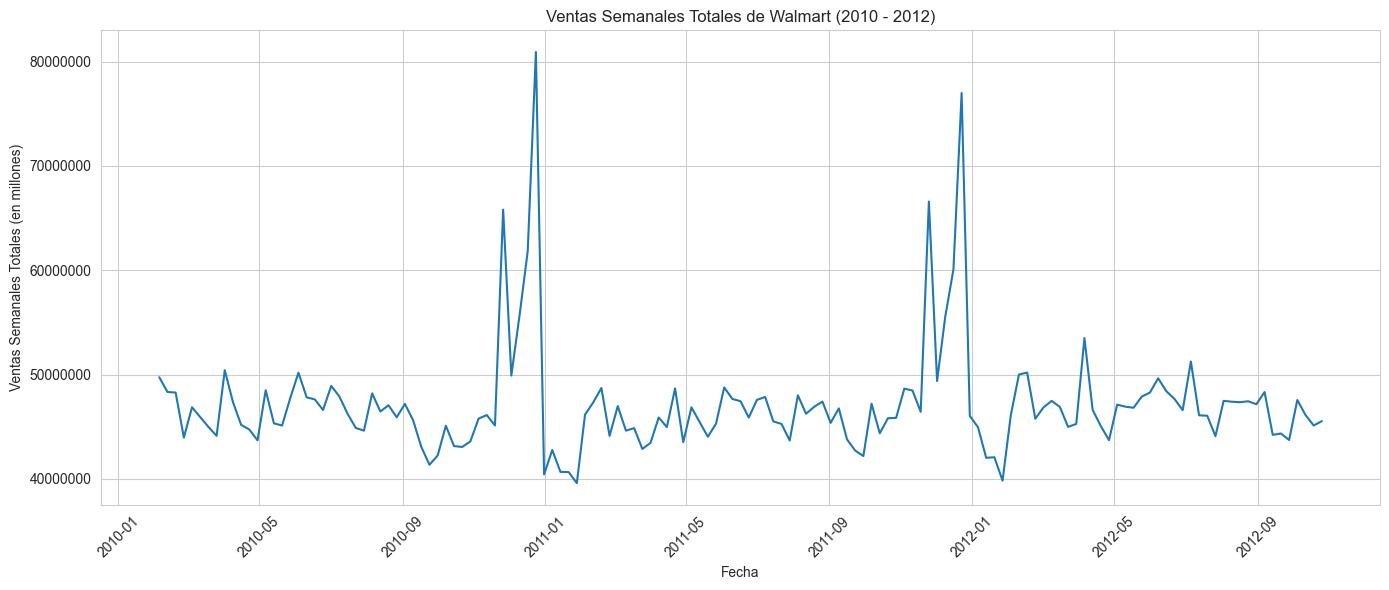

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Configuración inicial para una estética más agradable
sns.set_style("whitegrid") 

plt.figure(figsize=(14, 6))
# Gráfico de línea para la serie de tiempo
sns.lineplot(data=df_ventas_semanales, x='Date', y='Total_Weekly_Sales') 

plt.title('Ventas Semanales Totales de Walmart (2010 - 2012)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales Totales (en millones)')
plt.ticklabel_format(style='plain', axis='y') # Evita la notación científica en el eje Y
plt.xticks(rotation=45) # Rota las fechas para que sean legibles
plt.tight_layout() # Ajusta el diseño para que todo quepa
plt.show()

In [15]:
# 1. Agrupar por Tipo de Tienda ('Type')
df_store_type_analysis = df_final.groupby('Type').agg(
    # Calcular el total de ventas en el período
    Total_Sales=('Weekly_Sales', 'sum'),
    # Calcular el tamaño promedio de las tiendas de ese tipo
    Avg_Size=('Size', 'mean'),
    # Contar cuántas tiendas hay de cada tipo
    Store_Count=('Store', 'nunique')
).reset_index()

# 2. Ordenar por ventas totales (descendente)
df_store_type_analysis.sort_values(by='Total_Sales', ascending=False, inplace=True)

print("--- Análisis por Tipo de Tienda ---")
print(df_store_type_analysis)

--- Análisis por Tipo de Tienda ---
  Type   Total_Sales       Avg_Size  Store_Count
0    A  4.331015e+09  182231.285486           22
1    B  2.000701e+09  101818.735827           17
2    C  4.055035e+08   40535.725286            6


In [16]:
# 1. Calcular la Venta Promedio por Tienda (Total_Sales / Store_Count)
df_store_type_analysis['Avg_Sales_Per_Store'] = (
    df_store_type_analysis['Total_Sales'] / df_store_type_analysis['Store_Count']
)

# 2. Calcular la Venta Promedio por Tamaño (Total_Sales / (Avg_Size * Store_Count))
# Nota: La suma del tamaño es Avg_Size * Store_Count
df_store_type_analysis['Sales_Per_SqFt'] = (
    df_store_type_analysis['Total_Sales'] / (df_store_type_analysis['Avg_Size'] * df_store_type_analysis['Store_Count'])
)

# Formatear las columnas para que sean más legibles (quitando notación científica)
pd.options.display.float_format = '{:,.2f}'.format
print("--- Análisis de Eficiencia por Tipo de Tienda ---")
print(df_store_type_analysis[['Type', 'Total_Sales', 'Avg_Sales_Per_Store', 'Sales_Per_SqFt']])

--- Análisis de Eficiencia por Tipo de Tienda ---
  Type      Total_Sales  Avg_Sales_Per_Store  Sales_Per_SqFt
0    A 4,331,014,722.75       196,864,305.58        1,080.30
1    B 2,000,700,736.82       117,688,278.64        1,155.86
2    C   405,503,527.54        67,583,921.26        1,667.27


In [17]:
# Agrupar las ventas por la columna 'IsHoliday'
df_holiday_impact = df_final.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
df_holiday_impact.rename(columns={'Weekly_Sales': 'Mean_Weekly_Sales'}, inplace=True)

# Calcular el aumento porcentual
# Venta_Festiva - Venta_Normal / Venta_Normal
venta_normal = df_holiday_impact[df_holiday_impact['IsHoliday'] == False]['Mean_Weekly_Sales'].iloc[0]
venta_festiva = df_holiday_impact[df_holiday_impact['IsHoliday'] == True]['Mean_Weekly_Sales'].iloc[0]

aumento_pct = ((venta_festiva - venta_normal) / venta_normal) * 100

print("--- Impacto de Días Festivos en la Venta Semanal Promedio ---")
print(df_holiday_impact)
print(f"\nEl aumento porcentual en las ventas semanales promedio durante los días festivos es de: {aumento_pct:,.2f}%")

--- Impacto de Días Festivos en la Venta Semanal Promedio ---
   IsHoliday  Mean_Weekly_Sales
0      False          15,901.45
1       True          17,035.82

El aumento porcentual en las ventas semanales promedio durante los días festivos es de: 7.13%


In [18]:
# Guardar el DataFrame df_final limpio en la carpeta 'data'
df_final.to_csv('data/walmart_data_CLEANED.csv', index=False)

# Guardar el DataFrame de análisis por tipo de tienda, ya que es una tabla resumen clave
df_store_type_analysis.to_csv('data/store_type_analysis.csv', index=False)

print("\nArchivos CSV listos para Power BI:")
print("- walmart_data_CLEANED.csv (Datos transaccionales detallados)")
print("- store_type_analysis.csv (Métricas de eficiencia por tipo de tienda)")


Archivos CSV listos para Power BI:
- walmart_data_CLEANED.csv (Datos transaccionales detallados)
- store_type_analysis.csv (Métricas de eficiencia por tipo de tienda)


In [19]:
# 1. Seleccionar las columnas de interés
correlation_data = df_final[['Weekly_Sales', 'CPI', 'Unemployment', 'Temperature', 'Fuel_Price']]

# 2. Calcular la matriz de correlación (método de Pearson)
correlation_matrix = correlation_data.corr()

# 3. Extraer la correlación de Weekly_Sales con las otras variables
sales_correlation = correlation_matrix['Weekly_Sales'].sort_values(ascending=False)

print("--- Correlación de Ventas Semanales con Factores Económicos y Ambientales ---")
print(sales_correlation)

--- Correlación de Ventas Semanales con Factores Económicos y Ambientales ---
Weekly_Sales    1.00
Fuel_Price     -0.00
Temperature    -0.00
CPI            -0.02
Unemployment   -0.03
Name: Weekly_Sales, dtype: float64


In [21]:
# Función para asignar la estación basada en el mes (el mes ya existe en df_final)
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else: # 9, 10, 11
        return 'Fall'

# Aplicar la función al DataFrame df_final
df_final['Season'] = df_final['Month'].apply(get_season)

print("Columna 'Season' creada y verificada:")
print(df_final[['Date', 'Month', 'Season']].head())

Columna 'Season' creada y verificada:
        Date  Month  Season
0 2010-02-05      2  Winter
1 2010-02-12      2  Winter
2 2010-02-19      2  Winter
3 2010-02-26      2  Winter
4 2010-03-05      3  Spring


In [22]:
# Agrupar y calcular la Venta Semanal Promedio por Estación
df_season_analysis = df_final.groupby('Season')['Weekly_Sales'].mean().reset_index()

# Ordenar por el promedio de ventas (descendente)
df_season_analysis.sort_values(by='Weekly_Sales', ascending=False, inplace=True)

# Formatear la columna de ventas para mejor lectura
pd.options.display.float_format = '{:,.2f}'.format 

print("\n--- Ventas Semanales Promedio por Estación del Año ---")
print(df_season_analysis)


--- Ventas Semanales Promedio por Estación del Año ---
   Season  Weekly_Sales
3  Winter     16,632.33
2  Summer     16,077.97
0    Fall     15,716.27
1  Spring     15,610.93
